### 디렉토리 구조 확인하고 학습과 테스트용 메타 정보를 DataFrame으로 생성

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import numpy as np 
import pandas as pd 
import os

test_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
train_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv")

In [3]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### healthy, multiple_diseases, rust, scab 컬럼이 원핫 인코딩 형식으로 되어 있음. 

In [4]:
# healthy, multiple_diseases, rust, scab 컬럼을 합해서 sum을 만들고 sum이 1보다 큰지, 아니면 0인지 확인. 
train_df['sum'] = train_df['healthy'] + train_df['multiple_diseases'] + train_df['rust'] + train_df['scab']
train_df[(train_df['sum'] > 1) | (train_df['sum'] == 0)] 

,image_id,healthy,multiple_diseases,rust,scab,sum


### 이미지의 절대 경로를 DataFrame에 추가하고, 개별 컬럼별 0/1 값을 구분하여 클래스 라벨로 생성. 

In [5]:
pd.set_option("max_colwidth", 100)

IMAGE_DIR = '/kaggle/input/plant-pathology-2020-fgvc7/images'
train_df['path'] = IMAGE_DIR + '/' + train_df['image_id'] + '.jpg'
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,sum,path
0,Train_0,0,0,0,1,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_0.jpg
1,Train_1,0,1,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1.jpg
2,Train_2,1,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_2.jpg
3,Train_3,0,0,1,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg
4,Train_4,1,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_4.jpg


In [6]:
def get_label(x):
    if x['healthy'] == 1:
        return 'healthy'
    elif x['multiple_diseases'] == 1:
        return 'multiple_diseases'
    elif x['rust'] == 1:
        return 'rust'
    elif x['scab'] == 1:
        return 'scab'
    else: return 'None'


train_df['label'] = train_df.apply(lambda x:get_label(x), axis = 1)
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,sum,path,label
0,Train_0,0,0,0,1,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_0.jpg,scab
1,Train_1,0,1,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1.jpg,multiple_diseases
2,Train_2,1,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_2.jpg,healthy
3,Train_3,0,0,1,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg,rust
4,Train_4,1,0,0,0,1,/kaggle/input/plant-pathology-2020-fgvc7/images/Train_4.jpg,healthy


In [7]:
## 학습 이미지 건수 및 label별 건수
print('train shape:', train_df.shape)
print('label 별 건수')
train_df['label'].value_counts()

train shape: (1821, 8)
label 별 건수


rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

### 원본 이미지 시각화
* 녹병균 (Rust), 박테리아성 질환(scab), 복합질병(multiple_diseases), 건강(healthy)
* 이미지 size는 (1365, 2048)

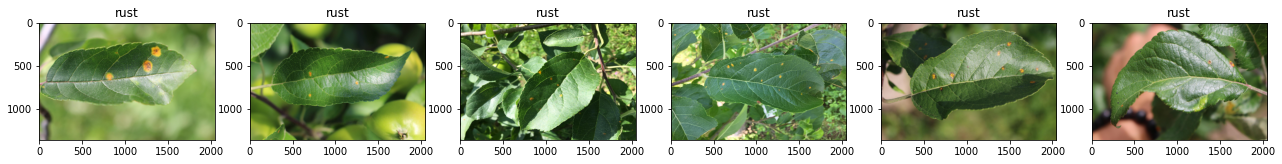

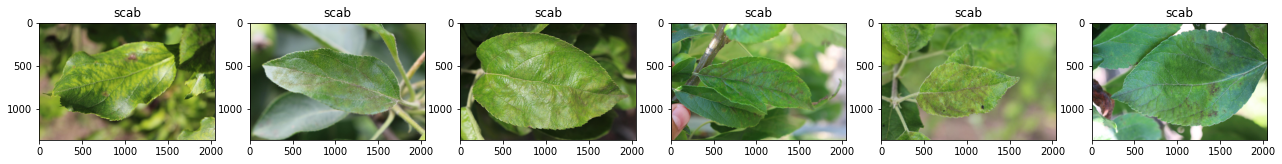

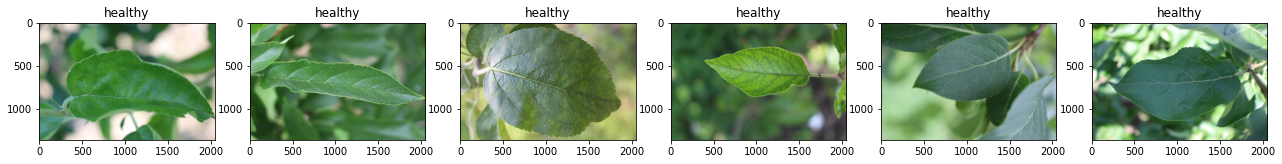

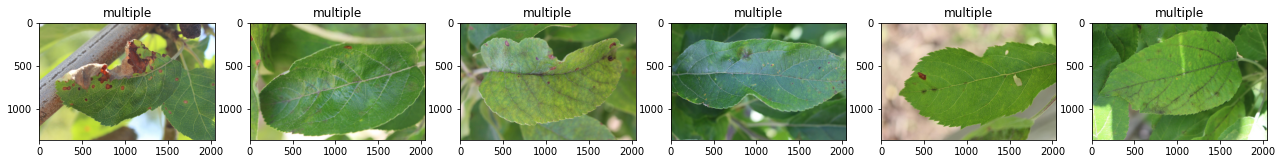

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 

def show_grid_images(image_path_list, augmentor = None, ncols = 4, title = None):
    figure, axs = plt.subplots(figsize = (22, 4), nrows = 1, ncols = ncols)
    for i in range(ncols):
        image = cv2.cvtColor(cv2.imread(image_path_list[i]), cv2.COLOR_BGR2RGB)
        if augmentor is not None:
            image = augmentor(image = image)['image']
        axs[i].imshow(image)
        #axs[i].axis('off')
        axs[i].set_title(title)
        #print(image.shape)
        
rust_image_list = train_df[train_df['label'] == 'rust']['path'].iloc[:6].tolist()
scab_image_list = train_df[train_df['label'] == 'scab']['path'].iloc[:6].tolist()
healthy_image_list = train_df[train_df['label'] == 'healthy']['path'].iloc[:6].tolist()
multiple_image_list = train_df[train_df['label'] == 'multiple_diseases']['path'].iloc[:6].tolist()

show_grid_images(rust_image_list, ncols = 6, title ='rust')
show_grid_images(scab_image_list, ncols = 6, title = 'scab')
show_grid_images(healthy_image_list, ncols = 6, title = 'healthy')
show_grid_images(multiple_image_list, ncols = 6, title = 'multiple')

### 이미지 Augmentation 적용. 
* cutout과 같은 noise는 나뭇잎의 병균 반점과 헷갈릴 수 있으므로 사용하지 않음. 
* 전체 이미지가 파란색 계열이고 병균 반점이 특정 색깔을 가지고 있으므로 색상의 변화는 적용하지 않음. 
* 전반적으로 판별하려는 나뭇잎이 전체 이미지의 중앙에 와있음. scale등의 적용 고려. 

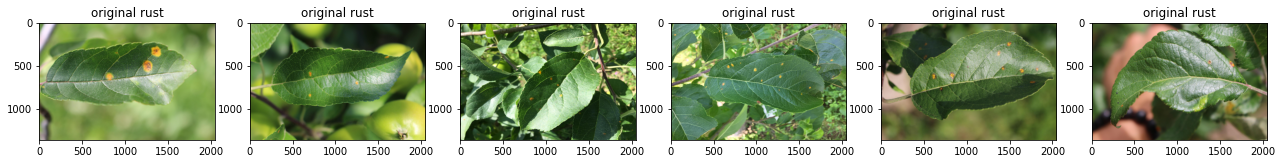

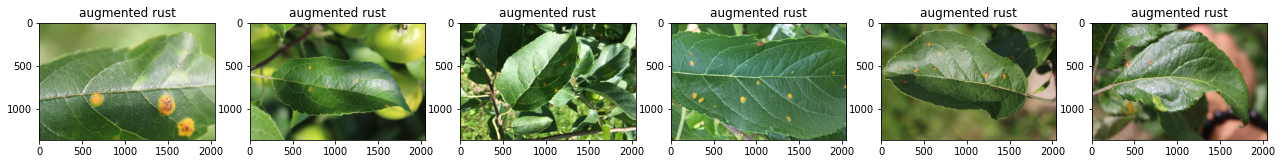

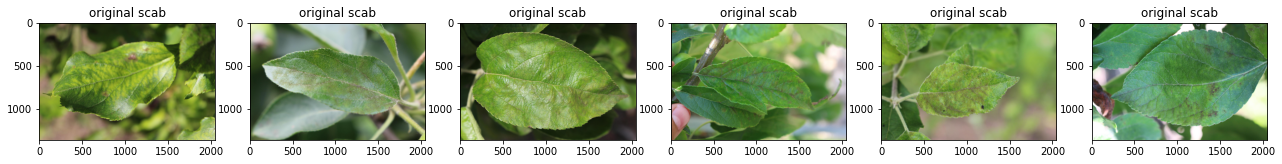

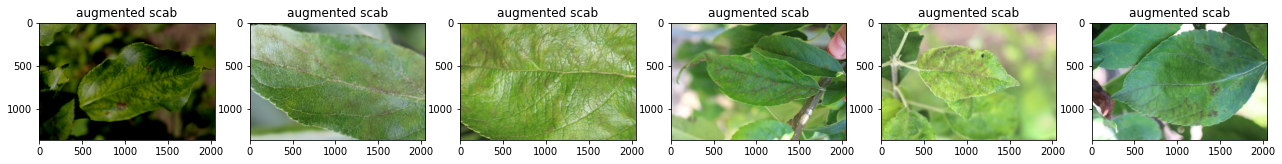

In [11]:
import albumentations as A

augmentor_01 = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.ShiftScaleRotate(scale_limit = (0.7, 0.9), p = 0.5, rotate_limit = 30),
    A.RandomBrightnessContrast(brightness_limit = (-0.2, 0.2), contrast_limit = (-0.2, 0.2), p = 0.5),
    A.Blur(p = 0.2)
])

show_grid_images(rust_image_list, augmentor = None, ncols = 6, title = 'original rust')
show_grid_images(rust_image_list, augmentor = augmentor_01, ncols = 6, title = 'augmented rust')

show_grid_images(scab_image_list, augmentor = None, ncols = 6, title = 'original scab')
show_grid_images(scab_image_list, augmentor = augmentor_01, ncols = 6, title = 'augmented scab')

### Sequence기반의 Dataset 생성
* 기존엔 image size가 높이와 너비가 동일하였으나, 이번엔 높이와 너비가 다를 수 있을 경우를 고려하여 image_size를 튜플로 입력
* opencv의 resize()는 인자로 이미지 크기를 입력 받는데 가로x세로(너비x높이)의 개념으로 입력 받음. 이미지 배열의 경우는 행x열(높이x너비) 이므로 resize()호출시 이를 감안할것. 
* 캐글 컴피티션에 테스트 데이터의 결과를 submit하므로 테스트 데이트의 Label이 없음. 때문에 Dataset의 label_batch 값이 None이 될 수 있는 경우를 감안해서 코드 재수정 필요. 

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import sklearn 
import cv2

# 입력 인자 image_filenames, labels는 모두 numpy array로 들어옴. image size는 (높이, 너비)로 수정. 
class Plant_Dataset(Sequence):
    def __init__(self, image_filenames, labels, image_size=(224, 224), batch_size=64, 
                 augmentor=None, shuffle=False, pre_func=None):
        '''
        파라미터 설명
        image_filenames: opencv로 image를 로드할 파일의 절대 경로들
        labels: 해당 image의 label들
        batch_size: __getitem__(self, index) 호출 시 마다 가져올 데이터 batch 건수
        augmentor: albumentations 객체
        shuffle: 학습 데이터의 경우 epoch 종료시마다 데이터를 섞을지 여부
        '''
        # 객체 생성 인자로 들어온 값을 객체 내부 변수로 할당. 
        self.image_filenames = image_filenames
        self.labels = labels
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.pre_func = pre_func
        # train data의 경우 
        self.shuffle = shuffle
        if self.shuffle:
            # 객체 생성시에 한번 데이터를 섞음. 
            #self.on_epoch_end()
            pass
    
    # Sequence를 상속받은 Dataset은 batch_size 단위로 입력된 데이터를 처리함. 
    # __len__()은 전체 데이터 건수가 주어졌을 때 batch_size단위로 몇번 데이터를 반환하는지 나타남
    def __len__(self):
        # batch_size단위로 데이터를 몇번 가져와야하는지 계산하기 위해 전체 데이터 건수를 batch_size로 나누되, 정수로 정확히 나눠지지 않을 경우 1회를 더한다. 
        return int(np.ceil(len(self.image_filenames) / self.batch_size))
    
    # batch_size 단위로 image_array, label_array 데이터를 가져와서 변환한 뒤 다시 반환함
    # 인자로 몇번째 batch 인지를 나타내는 index를 입력하면 해당 순서에 해당하는 batch_size 만큼의 데이타를 가공하여 반환
    # batch_size 갯수만큼 변환된 image_array와 label_array 반환. 
    def __getitem__(self, index):
        # index는 몇번째 batch인지를 나타냄. 
        # batch_size만큼 순차적으로 데이터를 가져오려면 array에서 index * self.batch_size : (index + 1) * self.batch_size 만큼의 연속 데이터를 가져오면 됨
        image_name_batch = self.image_filenames[index * self.batch_size : (index + 1) * self.batch_size]
        if self.labels is not None:
            label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        
        # label_batch가 None이 될 수 있음. 
        else: 
            label_batch = None
        # 만일 객체 생성 인자로 albumentation으로 만든 augmentor가 주어진다면 아래와 같이 augmentor를 이용하여 image 변환
        # albumentations은 개별 image만 변환할 수 있으므로 batch_size만큼 할당된 image_name_batch를 한 건씩 iteration하면서 변환 수행. 
        # image_batch 배열은 float32 로 설정. 
        image_batch = np.zeros((image_name_batch.shape[0], self.image_size[0], self.image_size[1], 3), dtype = 'float32')
        
        # batch_size에 담긴 건수만큼 iteration 하면서 opencv image load -> image augmentation 변환(augmentor가 not None일 경우)-> image_batch에 담음. 
        for image_index in range(image_name_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(image_name_batch[image_index]), cv2.COLOR_BGR2RGB)
            if self.augmentor is not None:
                image = self.augmentor(image = image)['image']
            #원본 이미지와 다르게 resize 적용. opencv의 resize은 (가로, 세로)의 개념임. 배열은 (높이, 너비)의 개념이므로 이에 주의하여 opencv resize 인자 입력 필요.  
            image = cv2.resize(image, (self.image_size[1], self.image_size[0]))
            # 만일 preprocessing_input이 pre_func인자로 들어오면 이를 이용하여 scaling 적용. 
            if self.pre_func is not None:
                image = self.pre_func(image)
                
            image_batch[image_index] = image
        
        return image_batch, label_batch
    
    # epoch가 한번 수행이 완료 될 때마다 모델의 fit()에서 호출됨. 
    def on_epoch_end(self):
        if(self.shuffle):
            #print('epoch end')
            # 전체 image 파일의 위치와 label를 쌍을 맞춰서 섞어준다. scikt learn의 utils.shuffle에서 해당 기능 제공
            self.image_filenames, self.labels = sklearn.utils.shuffle(self.image_filenames, self.labels)
        else:
            pass

### 학습 데이터용 DataFrame에서 학습용/검증용 이미지 절대 경로와 Label 추출하고 이를 Dataset으로 생성. 
* 이미 학습용 DataFrame에 'healthy', 'multiple_diseases', 'rust', 'scab' 순으로 원핫 인코딩 되어 있음. 
* 캐글에서 테스트 데이터 예측한 결과를 'healthy', 'multiple_diseases', 'rust', 'scab' 순서로 제출을 요구하므로 이를 별도로 다시 원-핫 인코딩 해서는 안됨. 
* Augmentation은 앞에서 생성한 augmentor_01을 적용. pre_func는 xception용 Preprocessing 함수 적용. 

In [13]:
sample_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [14]:
from sklearn.model_selection import train_test_split

def get_train_valid(train_df, valid_size = 0.2, random_state = 2021):
    train_path = train_df['path'].values
    # 별도의 원핫인코딩을 하지 않고  'healthy', 'multiple_diseases', 'rust', 'scab' 컬럼들을 모두 Numpy array로 변환하는 수준으로 label을 원핫 인코딩 적용. 
    train_label = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
    
    tr_path, val_path, tr_label, val_label = train_test_split(train_path, train_label, test_size = valid_size, random_state = random_state)
    print('tr_path shape:', tr_path.shape, 'tr_label shape:', tr_label.shape, 'val_path shape:', val_path.shape, 'val_label shape:', val_label.shape)
    return tr_path, val_path, tr_label, val_label

In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

# image size는 224x224로 Dataset 생성. 
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size = 0.2, random_state = 2021)

tr_ds = Plant_Dataset(tr_path, tr_label, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                          augmentor = augmentor_01, shuffle=True, pre_func = xcp_preprocess_input)
val_ds = Plant_Dataset(val_path, val_label, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                      augmentor = None, shuffle = False, pre_func = xcp_preprocess_input)

tr_image_batch, tr_label_batch = next(iter(tr_ds))
val_image_batch, val_label_batch = next(iter(val_ds))
print(tr_image_batch.shape, val_image_batch.shape, tr_label_batch.shape, val_label_batch.shape)
print(tr_image_batch[0], val_image_batch[0])

### create_model() 함수 생성. 
* resnet50v2, xception, efficientnetb0~b7 등의 Pretrained 모델을 생성 

In [36]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.metrics import AUC

from tensorflow.keras.applications import Xception, ResNet50V2, EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
import tensorflow as tf


def create_model(model_type = 'efficientnetb0', in_shape = (224, 224, 3), n_classes = 4):
    input_tensor = Input(shape = in_shape)

    if model_type == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'xception':
        base_model = tf.keras.applications.Xception(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb0':
        base_model = tf.keras.applications.EfficientNetB0(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb1':
        base_model = tf.keras.applications.EfficientNetB1(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb2':
        base_model = tf.keras.applications.EfficientNetB2(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb3':
        base_model = tf.keras.applications.EfficientNetB3(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb4':
        base_model = tf.keras.applications.EfficientNetB4(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb5':
        base_model = tf.keras.applications.EfficientNetB5(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb6':
        base_model = tf.keras.applications.EfficientNetB6(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
    elif model_type == 'efficientnetb7':
        base_model = tf.keras.applications.EfficientNetB7(include_top = False, weights = 'imagenet', input_tensor = input_tensor)
        
    x = base_model.output  
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)    
    preds = Dense(units = n_classes, activation = 'softmax')(x)
    model = Model(inputs = input_tensor, outputs = preds)
    

    return model

### xception 모델을 생성하고 학습 수행. 
* image size는 224x224로 생성. 
* Learning Rate Scheduler는 ReduceLROnPlateau로, 초기 Learning Rate는 0.0001로 설정. 
* epochs는 10회만 설정. 
* metrics는 ROC-AUC 설정

In [17]:
from tensorflow.keras.metrics import AUC

xcp_model_01 = create_model(model_type = 'xception', in_shape = (224, 224, 3))
xcp_model_01.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = [AUC()])

# 3번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, mode = 'min', verbose = 1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)

history = xcp_model_01.fit(tr_ds, epochs=10, steps_per_epoch = int(np.ceil(tr_path.shape[0] / BATCH_SIZE)), 
               validation_data = val_ds, validation_steps = int(np.ceil(val_path.shape[0] / BATCH_SIZE)),
               callbacks = ([rlr_cb, ely_cb]), verbose = 1)

2022-02-03 08:21:39.891425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 08:21:40.016441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 08:21:40.017623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 08:21:40.019193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-02-03 08:21:51.104063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-03 08:22:01.748388: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 122s 5s/step - loss: 1.0434 - auc: 0.8243 - val_loss: 0.8484 - val_auc: 0.8884
Epoch 2/10
23/23 [==============================] - 93s 4s/step - loss: 0.5312 - auc: 0.9537 - val_loss: 0.6672 - val_auc: 0.9412
Epoch 3/10
23/23 [==============================] - 92s 4s/step - loss: 0.3013 - auc: 0.9833 - val_loss: 0.5765 - val_auc: 0.9558
Epoch 4/10
23/23 [==============================] - 91s 4s/step - loss: 0.2450 - auc: 0.9897 - val_loss: 0.4893 - val_auc: 0.9656
Epoch 5/10
23/23 [==============================] - 92s 4s/step - loss: 0.1923 - auc: 0.9929 - val_loss: 0.4062 - val_auc: 0.9735
Epoch 6/10
23/23 [==============================] - 95s 4s/step - loss: 0.1730 - auc: 0.9935 - val_loss: 0.3733 - val_auc: 0.9717
Epoch 7/10
23/23 [==============================] - 94s 4s/step - loss: 0.1495 - auc: 0.9950 - val_loss: 0.2921 - val_auc: 0.9791
Epoch 8/10
23/23 [==============================] - 92s 4s/step - loss: 0.1430 - auc: 0.9954 - val_l

### 테스트 데이터로 Plant의 질병을 예측하고 캐글에 제출할 submit csv 파일 만들기
* 테스트용 DataFrame에 이미지 경로 추가. 
* 테스트용 Dataset 생성. label은 테스트 데이터에서 알 수 없으므로 None으로 입력

In [18]:
sample_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [19]:
IMAGE_DIR = '/kaggle/input/plant-pathology-2020-fgvc7/images'
test_df = pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv")
test_df['path'] = IMAGE_DIR + '/' + test_df['image_id'] + '.jpg'

test_df.head(10)

,image_id,path
0,Test_0,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_0.jpg
1,Test_1,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1.jpg
2,Test_2,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_2.jpg
3,Test_3,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_3.jpg
4,Test_4,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_4.jpg
5,Test_5,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_5.jpg
6,Test_6,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_6.jpg
7,Test_7,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_7.jpg
8,Test_8,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_8.jpg
9,Test_9,/kaggle/input/plant-pathology-2020-fgvc7/images/Test_9.jpg


In [20]:
# 테스트용 Dataset을 생성하고 이를 이용하여 model의 predict()를 호출하여 이미지 예측 수행. 

test_path = test_df['path'].values
# labels는 None을 입력하고 Dataset 생성. 
test_ds = Plant_Dataset(image_filenames = test_path, labels = None, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                        augmentor = None, shuffle = False, pre_func = xcp_preprocess_input)
#predict()로 예측 수행. 
preds = xcp_model_01.predict(test_ds)

In [21]:
preds_df = pd.DataFrame(preds)
preds_df.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
preds_df.head()

,healthy,multiple_diseases,rust,scab
0,2.304422e-05,0.000371,9.996046e-01,1.346112e-06
1,6.746830e-06,0.000906,9.990870e-01,4.418116e-07
2,1.581032e-07,0.000006,3.172745e-08,9.999934e-01
3,9.998636e-01,0.000002,1.301615e-04,4.555087e-06
4,6.301662e-05,0.004393,9.955225e-01,2.135712e-05


In [22]:
# 예측한 결과를 기반으로 별도의 결과 DataFrame을 생성. 
preds_df = pd.DataFrame(preds)
preds_df.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
# 테스트용 DataFrame에 바로 위에서 생성한 결과 DataFrame을 합친 뒤 이를 이용하여 submit용 DataFrame 생성.  
submit_df = pd.concat([test_df['image_id'], preds_df], axis = 1)
submit_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,2.304422e-05,0.000371,9.996046e-01,1.346112e-06
1,Test_1,6.746830e-06,0.000906,9.990870e-01,4.418116e-07
2,Test_2,1.581032e-07,0.000006,3.172745e-08,9.999934e-01
3,Test_3,9.998636e-01,0.000002,1.301615e-04,4.555087e-06
4,Test_4,6.301662e-05,0.004393,9.955225e-01,2.135712e-05


### 캐글 제출용 CSV 생성 후 캐글에 제출 및 테스트 성능 확인  

In [23]:
submit_df.to_csv('submit_01.csv', index = False)

In [24]:
def make_submit_df(test_df, model):
    test_path = test_df['path'].values
    # labels는 None을 입력하고 Dataset 생성. 
    test_ds = Plant_Dataset(image_filenames = test_path, labels = None, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                            augmentor = None, shuffle = False, pre_func = xcp_preprocess_input)
    #predict()로 예측 수행. 
    preds = model.predict(test_ds)
    
    # 예측한 결과를 기반으로 별도의 결과 DataFrame을 생성.
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # 테스트용 DataFrame에 바로 위에서 생성한 결과 DataFrame을 합친 뒤 이를 이용하여 submit용 DataFrame 생성.  
    submit_df = pd.concat([test_df['image_id'], preds_df], axis = 1)
    
    return submit_df

In [25]:
submit_df = make_submit_df(test_df, xcp_model_01)

submit_df.to_csv('submit_xcp_01.csv', index = False)

### image 사이즈를 변경하여 재 학습 수행. 
* xception 모델을 사용하되 원본 이미지(1365, 2048)의 ratio를 어느 정도 유지하면서 변경. 이미지 사이즈를 320, 512로 변경. 

In [26]:
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input

IMAGE_SIZE = (320, 512)
BATCH_SIZE = 64

tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size = 0.2, random_state = 2021)

tr_ds = Plant_Dataset(tr_path, tr_label, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                          augmentor = augmentor_01, shuffle = True, pre_func = xcp_preprocess_input)
val_ds = Plant_Dataset(val_path, val_label, image_size = IMAGE_SIZE, batch_size = BATCH_SIZE, 
                      augmentor = None, shuffle = False, pre_func = xcp_preprocess_input)

tr_image_batch, tr_label_batch = next(iter(tr_ds))
val_image_batch, val_label_batch = next(iter(val_ds))
print(tr_image_batch.shape, val_image_batch.shape, tr_label_batch.shape, val_label_batch.shape)
print(tr_image_batch[0], val_image_batch[0])

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)
(64, 320, 512, 3) (64, 320, 512, 3) (64, 4) (64, 4)
[[[-0.30196077  0.01176476 -0.38039213]
  [-0.29411763  0.0196079  -0.372549  ]
  [-0.30196077  0.00392163 -0.36470586]
  ...
  [-0.2862745   0.12941182 -0.38039213]
  [-0.25490195  0.16078436 -0.3333333 ]
  [-0.25490195  0.18431377 -0.30196077]]

 [[-0.29411763 -0.00392157 -0.3490196 ]
  [-0.29411763  0.01176476 -0.3490196 ]
  [-0.30196077  0.00392163 -0.3490196 ]
  ...
  [-0.372549    0.01176476 -0.5686275 ]
  [-0.29411763  0.082353   -0.49019605]
  [-0.23921567  0.13725495 -0.40392154]]

 [[-0.30196077  0.00392163 -0.3490196 ]
  [-0.29411763  0.00392163 -0.3333333 ]
  [-0.29411763  0.00392163 -0.31764704]
  ...
  [-0.41960782 -0.06666666 -0.6156863 ]
  [-0.38823527 -0.02745098 -0.58431375]
  [-0.3490196   0.00392163 -0.5372549 ]]

 ...

 [[-0.1372549   0.12156868 -0.10588235]
  [-0.2235294   0.03529418 -0.19215685]
  [-0.27843136 -0.01

### Config 를 이용하여 학습 수행. 
* 모델은 xception, image size는 (320, 512), 
* 초기 LR은 0.0001, LR Scheduler는 Ramp up and Step decay, 
* epochs는 10회, fine tuning을 적용하지 않음.
* augmentor는 앞에서 설정한 augmentor_01 적용. 

In [27]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess_input
from tensorflow.keras.applications.xception import preprocess_input as xcp_preprocess_input
import tensorflow as tf

# learning rate scheduler에 적용할 함수 선언. 
def lrfn_01(epoch):
    LR_START = 1e-5
    LR_MAX = 1e-4
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // 2)
        return lr
    
    return calc_fn(epoch)

def lrfn_02(epoch):
    LR_START = 1e-6
    LR_MAX = 2e-5
    LR_RAMPUP_EPOCHS = 2
    LR_SUSTAIN_EPOCHS = 1
    LR_STEP_DECAY = 0.75
    
    def calc_fn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = LR_MAX * LR_STEP_DECAY ** ((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) // 2)
        return lr
    
    return calc_fn(epoch)

# Config에 입력할 callback 생성. 
lr01_cb = tf.keras.callbacks.LearningRateScheduler(lrfn_01, verbose = 1)
lr02_cb = tf.keras.callbacks.LearningRateScheduler(lrfn_02, verbose = 1)
rlr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, mode = 'min', verbose = 1)

ely_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1)

# Augmentor 생성. 
augmentor_01 = A.Compose([
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.ShiftScaleRotate(scale_limit = (0.7, 0.9), p = 0.5, rotate_limit = 30),
    A.RandomBrightnessContrast(brightness_limit = (-0.2, 0.2), contrast_limit = (-0.2, 0.2), p = 0.5),
    A.Blur(p = 0.2)
])

# Config 생성. 
class Config:
    MODEL_TYPE = 'xception'
    IMAGE_SIZE = (320, 512)
    BATCH_SIZE = 32
    N_EPOCHS = 15 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = False
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 15 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = [lr01_cb, ely_cb] #모델 train시 적용될 callback 객체 리스트
    SECOND_CALLBACKS = [lr02_cb, ely_cb] #만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = augmentor_01
    PRE_FUNC = xcp_preprocess_input
    INITIAL_LR = 0.0001
    DEBUG = True

In [28]:
def train_model(train_df, config = Config):
    # 학습과 검증 데이터 이미지/레이블로 분리하고 학습/검증 Dataset 생성. 
    tr_path, val_path, tr_label, val_label = get_train_valid(train_df, valid_size = 0.2, random_state = 2021)
    
    tr_ds = Plant_Dataset(tr_path, tr_label, image_size = config.IMAGE_SIZE, batch_size = config.BATCH_SIZE, 
                          augmentor = config.AUGMENTOR, shuffle = True, pre_func = config.PRE_FUNC)
    val_ds = Plant_Dataset(val_path, val_label, image_size = config.IMAGE_SIZE, batch_size = config.BATCH_SIZE, 
                          augmentor = None, shuffle = False, pre_func = config.PRE_FUNC)
    if config.DEBUG:
        tr_image_batch = next(iter(tr_ds))[0]
        val_image_batch = next(iter(val_ds))[0]
        print(tr_image_batch.shape, val_image_batch.shape)
        print(tr_image_batch[0], val_image_batch[0])
        
    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', config.MODEL_TYPE, ' 생성 및 학습 수행 ########')
    model = create_model(model_type = config.MODEL_TYPE, in_shape = (config.IMAGE_SIZE[0], config.IMAGE_SIZE[1], 3), n_classes = 4)
    model.compile(optimizer = Adam(lr = config.INITIAL_LR), loss = 'categorical_crossentropy', metrics = [AUC()])
    
    # 만일 Fine tuning 일 경우 아래 로직 적용. 
    if config.IS_FINE_TUNING:
        print('####### Fine tuning 학습을 시작합니다. ########')
        # 첫번째 Fine Tuning. Feature Extractor를 제외한 classification layer를 학습.(Feature Extractor layer들을 trainable=False 설정)
        for layer in model.layers[:-4]:
            layer.trainable = False
        
        print('####### Classification Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.FIRST_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                           validation_data = val_ds, validation_steps = int(np.ceil(val_path.shape[0] / config.BATCH_SIZE)),
                           callbacks = (config.FIRST_CALLBACKS), verbose = 1)
        
        # 두번째, 전체 Layer를 학습. 전체 layer를 trainable=True로 수정. 모델이 EfficientNet 계열일 경우 Batch Normalization layer는 학습 제외. 
        for layer in model.layers:
            if config.MODEL_TYPE in 'efficientnet':
                if not isinstance(layer, layers.BatchNormalization):
                    layer.trainable = True
            else:
                layer.trainable = True
        
        print('####### 전체 Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.SECOND_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                           validation_data = val_ds, validation_steps = int(np.ceil(val_path.shape[0] / config.BATCH_SIZE)),
                           callbacks = (config.SECOND_CALLBACKS), verbose = 1)
    
    # Fine Tuning이 아닐 경우 
    else:
        print('####### 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.N_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                       validation_data = val_ds, validation_steps = int(np.ceil(val_path.shape[0] / config.BATCH_SIZE)),
                       callbacks = (config.FIRST_CALLBACKS), verbose = 1)
        
    return model, history

In [29]:
xcp_model_02, history = train_model(train_df, config=Config)

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)
(32, 320, 512, 3) (32, 320, 512, 3)
[[[0.7647059  1.         0.58431375]
  [0.75686276 1.         0.5921569 ]
  [0.7490196  1.         0.6156863 ]
  ...
  [0.60784316 1.         0.5686275 ]
  [0.60784316 0.99215686 0.5294118 ]
  [0.58431375 0.96862745 0.4901961 ]]

 [[0.75686276 1.         0.58431375]
  [0.75686276 1.         0.6       ]
  [0.7411765  1.         0.62352943]
  ...
  [0.5921569  1.         0.56078434]
  [0.60784316 0.99215686 0.5294118 ]
  [0.58431375 0.96862745 0.4901961 ]]

 [[0.75686276 1.         0.6       ]
  [0.75686276 1.         0.6156863 ]
  [0.7411765  1.         0.6313726 ]
  ...
  [0.5921569  1.         0.56078434]
  [0.60784316 1.         0.5372549 ]
  [0.5921569  0.9764706  0.49803925]]

 ...

 [[0.7411765  0.7647059  0.49803925]
  [0.73333335 0.77254903 0.5058824 ]
  [0.6784314  0.73333335 0.45882356]
  ...
  [0.8117647  0.81960785 0.58431375]
  [0.81960785 0.

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


####### 학습을 시작합니다. ########
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


2022-02-03 08:44:49.988077: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 08:44:50.101914: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 08:44:50.115487: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


46/46 [==============================] - 125s 3s/step - loss: 1.2877 - auc_1: 0.6675 - val_loss: 1.2104 - val_auc_1: 0.7542
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 5.5e-05.
46/46 [==============================] - 119s 3s/step - loss: 0.7955 - auc_1: 0.9115 - val_loss: 0.6828 - val_auc_1: 0.9247
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
46/46 [==============================] - 115s 3s/step - loss: 0.2910 - auc_1: 0.9847 - val_loss: 0.3227 - val_auc_1: 0.9784
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
46/46 [==============================] - 115s 2s/step - loss: 0.2125 - auc_1: 0.9905 - val_loss: 0.3091 - val_auc_1: 0.9784
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
46/46 [==============================] - 115s 2s/step - loss: 0.1543 - auc_1: 0.9952 - val_loss: 0.2361 - val_auc_1: 0.9859
Epoch 6/15

Epoch 00006: LearningRateScheduler setting lear

### 학습된 모델을 이용하여 테스트 이미지 예측 및 결과 제출 

In [30]:
def make_submit_df(test_df, model, config = Config):
    test_path = test_df['path'].values
    # labels는 None을 입력하고 Dataset 생성. 
    test_ds = Plant_Dataset(image_filenames = test_path, labels = None, image_size = config.IMAGE_SIZE, batch_size = config.BATCH_SIZE, 
                            augmentor = None, shuffle = False, pre_func = config.PRE_FUNC)
    #predict()로 예측 수행. 
    preds = model.predict(test_ds)
    
    # 예측한 결과를 기반으로 별도의 결과 DataFrame을 생성.
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # 테스트용 DataFrame에 바로 위에서 생성한 결과 DataFrame을 합친 뒤 이를 이용하여 submit용 DataFrame 생성.  
    submit_df = pd.concat([test_df['image_id'], preds_df], axis = 1)
    
    return submit_df

In [31]:
submit_df = make_submit_df(test_df, xcp_model_02, config = Config)

submit_df.to_csv('submit_xcp_02.csv', index = False)

### EfficientNetB3로 Pretrained 모델을 변경한 후 다시 학습 및 테스트 데이터 평가 후 제출. 
* BATCH_SIZE를 16으로 줄이지 않으면 OOM 오류 발생. 

In [34]:
# Config 생성. 
class Config:
    MODEL_TYPE = 'efficientnetb3'
    IMAGE_SIZE = (320, 512)
    BATCH_SIZE = 16
    N_EPOCHS = 15 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = False
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 15 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = [lr01_cb, ely_cb] #모델 train시 적용될 callback 객체 리스트
    SECOND_CALLBACKS = [lr02_cb, ely_cb] #만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = augmentor_01
    PRE_FUNC = eff_preprocess_input
    INITIAL_LR = 0.0001
    DEBUG = False

In [37]:
effb3_model, history = train_model(train_df, config = Config)

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)
####### efficientnetb3  생성 및 학습 수행 ########
43950080/43941136 [==============================] - 1s 0us/step
####### 학습을 시작합니다. ########
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
91/91 [==============================] - 133s 1s/step - loss: 1.3141 - auc_2: 0.6380 - val_loss: 1.2752 - val_auc_2: 0.7009
Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 5.5e-05.
91/91 [==============================] - 112s 1s/step - loss: 0.7524 - auc_2: 0.9205 - val_loss: 0.3689 - val_auc_2: 0.9709
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
91/91 [==============================] - 114s 1s/step - loss: 0.3020 - auc_2: 0.9833 - val_loss: 0.2780 - val_auc_2: 0.9820
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
91/91 [==============================] - 112s 1s/step - loss: 0.2561 - au

In [38]:
submit_df = make_submit_df(test_df, effb3_model, config = Config)

submit_df.to_csv('submit_effb3.csv', index=False)

### EfficientNetB5로 Pretrained 모델을 변경한 후 다시 학습 및 테스트 데이터 평가 후 제출. 
* IMAGE_SIZE는 (456, 456)으로 증가.  
* BATCH_SIZE를 8로 줄이지 않으면 OOM 오류 발생. 

In [41]:
class Config:
    MODEL_TYPE = 'efficientnetb5'
    IMAGE_SIZE = (456, 456)
    BATCH_SIZE = 8
    N_EPOCHS = 15 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = False
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 15 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = [lr01_cb, ely_cb] #모델 train시 적용될 callback 객체 리스트
    SECOND_CALLBACKS = [lr02_cb, ely_cb] #만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = augmentor_01
    PRE_FUNC = eff_preprocess_input
    INITIAL_LR = 0.0001
    DEBUG = False

In [42]:
effb5_model, history = train_model(train_df, config = Config)

tr_path shape: (1456,) tr_label shape: (1456, 4) val_path shape: (365,) val_label shape: (365, 4)
####### efficientnetb5  생성 및 학습 수행 ########
####### 학습을 시작합니다. ########
Epoch 1/15

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


2022-02-03 09:52:44.180049: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 09:52:44.245688: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 09:52:44.253064: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 09:52:44.288872: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

182/182 [==============================] - 194s 932ms/step - loss: 1.2637 - auc_4: 0.7085 - val_loss: 1.0597 - val_auc_4: 0.8804


2022-02-03 09:55:33.998820: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 09:55:34.024728: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/15

Epoch 00002: LearningRateScheduler setting learning rate to 5.5e-05.
182/182 [==============================] - 165s 907ms/step - loss: 0.5447 - auc_4: 0.9532 - val_loss: 0.2916 - val_auc_4: 0.9790
Epoch 3/15

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
182/182 [==============================] - 166s 910ms/step - loss: 0.3509 - auc_4: 0.9776 - val_loss: 0.2650 - val_auc_4: 0.9823
Epoch 4/15

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
182/182 [==============================] - 165s 902ms/step - loss: 0.2667 - auc_4: 0.9858 - val_loss: 0.2677 - val_auc_4: 0.9818
Epoch 5/15

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
182/182 [==============================] - 165s 902ms/step - loss: 0.2274 - auc_4: 0.9884 - val_loss: 0.2078 - val_auc_4: 0.9927
Epoch 6/15

Epoch 00006: LearningRateScheduler setting learning rate to 7.500000000000001e-05.
182/182 [==============================] - 165s 907ms/step - loss: 0

In [43]:
submit_df = make_submit_df(test_df, effb5_model, config = Config)

submit_df.to_csv('submit_effb5.csv', index = False)

### EfficientNetB7로 Pretrained 모델을 변경한 후 다시 학습 및 테스트 데이터 평가 후 제출. 
* 기존 검증 데이터를 합쳐서 학습 데이터로 활용. 
* IMAGE_SIZE는 (456, 456)으로 유지.  
* BATCH_SIZE를 4로 줄이지 않으면 OOM 오류 발생. 

In [44]:
class Config:
    MODEL_TYPE = 'efficientnetb7'
    IMAGE_SIZE = (456, 456)
    BATCH_SIZE = 4
    N_EPOCHS = 20 # fine tuning이 아닐 경우 전체 수행 epoch 횟수
    IS_FINE_TUNING = False
    FIRST_EPOCHS = 15 # fine tuning 일 경우 첫번째 epoch 횟수
    SECOND_EPOCHS = 15 # fine tuning 일 경우 두번째 epoch 횟수
    FIRST_CALLBACKS = [lr01_cb, ely_cb] #모델 train시 적용될 callback 객체 리스트
    SECOND_CALLBACKS = [lr02_cb, ely_cb] #만일 Fine tuning 시 첫번째 학습과 두번째 학습의 Learning rate scheduler가 서로 다를 경우 사용. 
    AUGMENTOR = augmentor_01
    PRE_FUNC = eff_preprocess_input
    INITIAL_LR = 0.0001
    DEBUG = False

In [45]:
def train_only_model(train_df, config = Config):
    # 학습과 검증 데이터 이미지/레이블로 분리하고 학습/검증 Dataset 생성. 
    train_path = train_df['path'].values
    # 별도의 원핫인코딩을 하지 않고  'healthy', 'multiple_diseases', 'rust', 'scab' 컬럼들을 모두 Numpy array로 변환하는 수준으로 label을 원핫 인코딩 적용. 
    train_label = train_df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
    
    tr_ds = Plant_Dataset(train_path, train_label, image_size = config.IMAGE_SIZE, batch_size = config.BATCH_SIZE, 
                          augmentor = config.AUGMENTOR, shuffle = True, pre_func = config.PRE_FUNC)
    if config.DEBUG:
        tr_image_batch = next(iter(tr_ds))[0]
        print(tr_image_batch.shape)
        print(tr_image_batch[0])
        
    # model_type인자로 들어온 모델 생성. optimizer Adam적용. 
    print('#######', config.MODEL_TYPE, ' 생성 및 학습 수행 ########')
    model = create_model(model_type = config.MODEL_TYPE, in_shape = (config.IMAGE_SIZE[0], config.IMAGE_SIZE[1], 3), n_classes = 4)
    model.compile(optimizer = Adam(lr = config.INITIAL_LR), loss = 'categorical_crossentropy', metrics = [AUC()])
    
    # 만일 Fine tuning 일 경우 아래 로직 적용. 
    if config.IS_FINE_TUNING:
        print('####### Fine tuning 학습을 시작합니다. ########')
        # 첫번째 Fine Tuning. Feature Extractor를 제외한 classification layer를 학습.(Feature Extractor layer들을 trainable=False 설정)
        for layer in model.layers[:-4]:
            layer.trainable = False
        
        print('####### Classification Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.FIRST_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                           #validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                           callbacks = (config.FIRST_CALLBACKS), verbose = 1)
        
        # 두번째, 전체 Layer를 학습. 전체 layer를 trainable=True로 수정. 모델이 EfficientNet 계열일 경우 Batch Normalization layer는 학습 제외. 
        for layer in model.layers:
            if config.MODEL_TYPE in 'efficientnet':
                if not isinstance(layer, layers.BatchNormalization):
                    layer.trainable = True
            else:
                layer.trainable = True
        
        print('####### 전체 Layer들의 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.SECOND_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                           #validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                           callbacks = (config.SECOND_CALLBACKS), verbose = 1)
    
    # Fine Tuning이 아닐 경우 
    else:
        print('####### 학습을 시작합니다. ########')
        history = model.fit(tr_ds, epochs = config.N_EPOCHS, steps_per_epoch = int(np.ceil(tr_path.shape[0] / config.BATCH_SIZE)), 
                       #validation_data=val_ds, validation_steps=int(np.ceil(val_path.shape[0]/config.BATCH_SIZE)),
                       callbacks = (config.FIRST_CALLBACKS), verbose = 1)
        
    return model, history

In [46]:
effb7_model, history = train_only_model(train_df, config = Config)

####### efficientnetb7  생성 및 학습 수행 ########
258088960/258076736 [==============================] - 5s 0us/step
####### 학습을 시작합니다. ########
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
364/364 [==============================] - 317s 774ms/step - loss: 1.1645 - auc_5: 0.7788
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 5.5e-05.
364/364 [==============================] - 280s 769ms/step - loss: 0.5906 - auc_5: 0.9398
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
364/364 [==============================] - 281s 771ms/step - loss: 0.4398 - auc_5: 0.9654
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
364/364 [==============================] - 281s 773ms/step - loss: 0.3659 - auc_5: 0.9737
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
364/364 [==============================] - 282s 773ms/step - loss: 0.3017 - auc_5: 0.9816
Epoch 6/20


In [47]:
submit_df = make_submit_df(test_df, effb7_model, config = Config)
submit_df.to_csv('submit_effb7.csv', index = False)